# Evaluating $\ell_2$ vs. $\ell_{CK}$ error

In this notebook we take as an input (mostly) sine data with varying frequency 
as it turned to be "harder" to fit in terms of remaining approximation and continuity error in previous notebooks (as expected).
We observe remaining l2 vs. C^k error for different alphas, noise levels and initializations of polynomial coefficients.

Version 2.0
Date: 2024-01-18
Current version: hannes.waclawek@fh-salzburg.ac.at

# Findings

### Initialization of polynomial coefficients
$\ell_2$ initialization turns out to be the best choice, as it performs clearly the best for "unnoisy" data.
For noisy data, zero spline initialization is slightly ahead, but $\ell_2$ initialization is competitive.

### Strictly establishing continuity after optimization
Strictly establishing continuity per algorithm for an optimization result with alpha $>0$ leads to numerical continuity and affects prior approximation errors only mildly. 
Strictly establishing continuity for a result with alpha = 0 increases the remaining approximation error significantly.

### Variance of input data / Choosing alpha
Interestingly, in most observed experiments, an alpha value of 0.0 does not necessarily lead to a better approximation result compared to higher alpha values.
This shows that $\ell_2$ optimization, in some scenarios, can benefit from $\ell_{CK}$ optimization.

Which alpha to choose highly depends on the given input data and number of polynomials.
The band between remaining approximation error of a conventional least squares fit and approximation error of this fit after strictly establishing continuity via algorithm
depends on the remaining discontinuities at boundary points after fitting. 
These tend to be higher with noisy data / data with more variance / lower number of polynomials, leaving us with a wider band of where our optimization leads to better results than performing
l2 fit with strict continuity establishment.
In case of a wider band, we can also have a wider range of alpha values that make sense.
Leaving out some scenarios where local optima of higher alpha values have a lower approximation error than lower ones,
we generally see a tendency of rising approximation errors with rising alpha values.
For high variance / noisy input data, we observe results that lie within the aforementioned band through the range 0 < alpha <~ 0.9,
with alpha values of > ~0.9 tendentially having ever higher approximation errors, thus leaving the band.

With low variance data, this effect already can be observed with lambda values > ~0.3, leaving us with a smaller range of possible alphas that make sense.

In [16]:
import copy

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata, animate

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
colors = list(mcolors.TABLEAU_COLORS.keys())
color_map = plt.get_cmap('gist_rainbow')

## Data

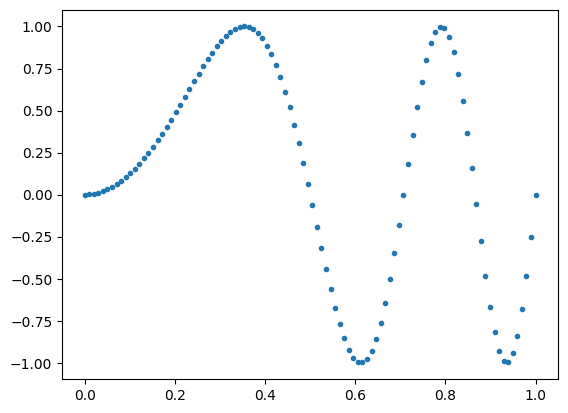

In [19]:
xsinvar = np.linspace(0, 1, 100)
ysinvar = np.sin(xsinvar**2 * 4 * np.pi)

plt.plot(xsinvar, ysinvar, '.')

Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

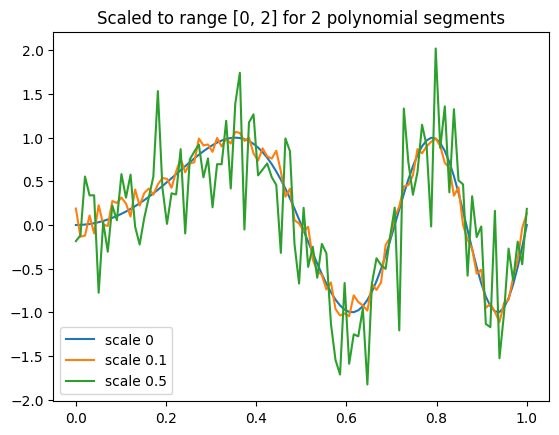

In [20]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scales = [0.0, 0.1, 0.5]
ys2gauss = [ysinvar + np.random.normal(scale=s, size=len(ysinvar)) for s in ys2gauss_scales]

for i, ysn in enumerate(ys2gauss):
    plt.plot(xsinvar, ysn, '-', label='scale %.2g' % ys2gauss_scales[i])
plt.legend(loc="best")
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

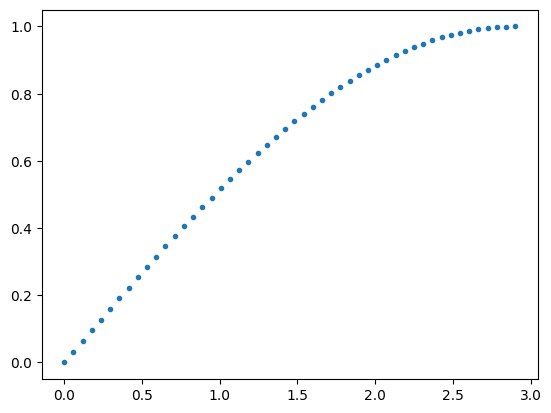

In [147]:
# The data set to approximate with x and y samples
xss_ori = np.linspace(0, 0.5*np.pi, 100, dtype="double")
xss = sampledata.rescale_input_data(xss_ori, 1)
xs2_ori = np.linspace(0, 0.5*np.pi, 50)
ys2 = np.sin(xs2_ori)
#plt.plot(xs2_ori, ys2, '.')
xs2 = sampledata.rescale_input_data(xs2_ori, 2.9)
plt.plot(xs2, ys2, '.')

In [21]:
def generate_l2_over_lck_plot_data(params, data_x, data_y, polynum, ck, degree, epochs, alpha, learning_rate=0.1, ck_regularization=True, basis='chebyshev', optimizer='amsgrad', early_stopping=False, patience=100, mode='fixed_alpha'):
    initialization = 'random'
    
    if mode == 'fixed_alpha':
        m = 'random_init_seed'
    elif mode == 'fixed_l2':
        m = 'lambda'
        initialization = 'l2'
    elif mode == 'fixed_l2_enforce_ck':
        m = 'lambda_enforced_continuity'
        initialization = 'l2'
    elif mode == 'fixed_seed_enforce_ck':
        m = 'lambda_enforced_continuity'
        initialization = 'random'
    else:
        m = 'lambda'
    
    kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': polynum, 'ck': ck, 'degree': degree,
        'optimizer': optimizer, 'n_epochs': epochs, 'basis': basis, 'learning_rate': learning_rate, 
        'ck_regularization': ck_regularization, 'factor_ck_pressure':alpha, 'factor_approximation_quality':1-alpha, 'mode': m,
        'early_stopping': early_stopping, 'patience': patience, 'initialization': initialization, 'seed': 0}

    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

    return results

In [145]:
def plot_l2_over_lck_plot(results, params, data_x, data_y, ck, alpha, basis, optimizer, mode='fixed_alpha', early_stopping=False, digits=3, input='Noisy', xlim=None, ylim=None):
    if mode == 'fixed_alpha':
        labeltext = 'seed'
        title = f'{basis} & {optimizer}: Continuity over Approximation error for different random initializations, C^{ck} \nalpha = {alpha}, degree {degree}, {epochs} epochs, {input} input, {polynum} segments, Early stopping = {early_stopping}'
    elif mode == 'fixed_seed':
        labeltext = 'alpha'
        title = f'{basis} & {optimizer}: Continuity over Approximation error for different alphas, C^{ck} \ndegree {degree}, {epochs} epochs, {input} input, {polynum} segments, Early stopping = {early_stopping}'
    elif mode ==  'fixed_l2':
        labeltext = 'alpha'
        title = f'{basis} & {optimizer}: Continuity over Approximation error for different alphas, l2 initialization, C^{ck} \ndegree {degree}, {epochs} epochs, {input} input, {polynum} segments, Early stopping = {early_stopping}'
    elif mode == 'fixed_l2_enforce_ck':
        labeltext = 'alpha'
        title = f'{basis} & {optimizer}: Continuity over Approximation error for different alphas, l2 initialization, C^{ck} \nenforced continuity after optimization, degree {degree}, {epochs} epochs, {input} input, {polynum} segments, Early stopping = {early_stopping}'
    elif mode == 'fixed_seed_enforce_ck':
        labeltext = 'alpha'
        title = f'{basis} & {optimizer}: Continuity over Approximation error for different alphas, fixed seed, C^{ck} \nenforced continuity after optimization, degree {degree}, {epochs} epochs, {input} input, {polynum} segments, Early stopping = {early_stopping}'
    else:
        raise Exception('Not implemented.')
    
    splines_results = [0.0] * len(results)

    for i in range(len(results)):
        splines_results[i] = model.get_spline_from_coeffs(results[i][-1], data_x, data_y, basis='chebyshev', ck=ck, total_loss_values=copy.copy(results[i][1]), e_loss_values=copy.copy(results[i][2]), D_loss_values=copy.copy(results[i][3]))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(12)
    fig.set_figheight(6)
    fig.suptitle(title)
    
    #ax.set_prop_cycle(color=[color_map(1.*i/len(params)) for i in range(len(params))])
    mycolor = lambda i: color_map(1.*i/len(params))
    
    if mode == 'fixed_alpha':
        ax.loglog(results[0][2], results[0][3], label=f'l2', color=mycolor(0), alpha=0.5)
        ax.plot(results[0][2][-1], results[0][3][-1], '*', color=mycolor(0))
        
        ax.loglog(results[1][2], results[1][3], label=f'zero spline', color=mycolor(1), alpha=0.5)
        ax.plot(results[1][2][-1], results[1][3][-1], '*', color=mycolor(1))
        
        for i in range(2, len(params)):
            ax.loglog(results[i][2], results[i][3], label=f'{labeltext} = {params[i]:}', color=mycolor(i), alpha=0.5)
            ax.plot(results[i][2][-1], results[i][3][-1], '*', color=mycolor(i))
        enforced_cont_spline = model.get_spline_from_coeffs(results[0][-1], data_x, data_y, basis='chebyshev', ck=ck, total_loss_values=copy.copy(results[0][1]), e_loss_values=copy.copy(results[0][2]), D_loss_values=copy.copy(results[0][3]))
        enforced_cont_spline._establish_continuity()
        enforced_cont_spline._append_current_losses()
        ax.axvline(enforced_cont_spline.e_loss_values[-1], linestyle="--", color=colors[2], label=f'enforced ck after opt, l2 init') 
    else:
        for i in range(len(params)):
            ax.loglog(results[i][2], results[i][3], label=f'{labeltext} = {params[i]:.{digits}f}', color=mycolor(i), alpha=0.5)
            ax.plot(results[i][2][-1], results[i][3][-1], '*', color=mycolor(i))
        # enforced_cont_spline = model.get_spline_from_coeffs(results[-1][-1], data_x, data_y, basis='power', ck=ck, total_loss_values=results[-1][1], e_loss_values=results[-1][2], D_loss_values=results[-1][3])
        # enforced_cont_spline._establish_continuity()
        # enforced_cont_spline._append_current_losses()
        # ax.axvline(enforced_cont_spline.e_loss_values[-1], linestyle="--", color=colors[2], label=f'enforced ck after opt, highest alpha')
    
    baseline_loss = plot.get_l2_baseline_error(splines_results[1], ck_loss=True, ck=ck)
    ax.axvline(baseline_loss[0], linestyle="--", color=colors[0], label='min l2')
    ax.plot(baseline_loss[0], baseline_loss[1].numpy(), marker='x', color=colors[0], markersize=10)
    
    l2coeffs = plot.get_l2_baseline_coeffs(splines_results[1])
    continuous_l2_result = model.get_spline_from_numpy_coeffs(l2coeffs, splines_results[1].data_x, splines_results[1].data_y, ck=ck)
    continuous_l2_result._establish_continuity()
    continuous_l2_result._append_current_losses()
    ax.axvline(continuous_l2_result.e_loss_values[-1], linestyle="--", color=colors[1], label='min l2 enforced ck')
    #ax.plot(continuous_l2_result._sum_squared_errors(), alpha*continuous_l2_result.ck_pressure()[-1], marker='*', color=colors[0], markersize=10)
    
    ax.legend(loc='best')
    ax.set_xlabel('$\ell_2$', fontsize=15)
    ax.set_ylabel('$\ell_{CK}$', fontsize=15)
    ax.grid(which='both', axis='x')
    ax.grid(axis='y')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# $\ell_{CK}$ over $\ell_2$ vs. $\ell_2$ baseline

### Parameters

In [82]:
optimizer = 'amsgrad'
ck_regularization = True
early_stopping = True
patience = 500
alpha = 0.1
learning_rate = 0.1
basis = 'chebyshev'
degree = 7
ck = 3

# Noisy Sine data with increasing frequency

## Where do different seeds end up for a fixed alpha?

### alpha = 0.1

In [83]:
params = np.arange(-2, 5, 1)
polynum = 3
epochs = 2000

In [26]:
ellck_overell2_seed_results = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results

Stored 'ellck_overell2_seed_results' (list)


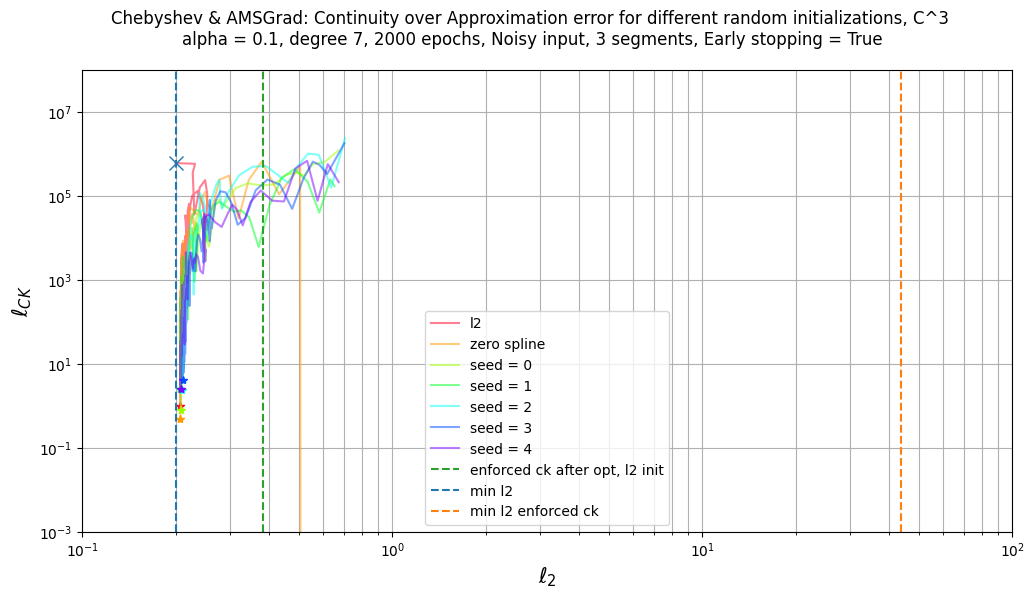

In [84]:
%store -r ellck_overell2_seed_results
plot_l2_over_lck_plot(ellck_overell2_seed_results, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_alpha',early_stopping=early_stopping, xlim=(1e-1,1e2), ylim=(1e-3,1e8))

### No regularization

In [28]:
ellck_overell2_seed_results_no_reg = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, False, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results_no_reg

Stored 'ellck_overell2_seed_results_no_reg' (list)


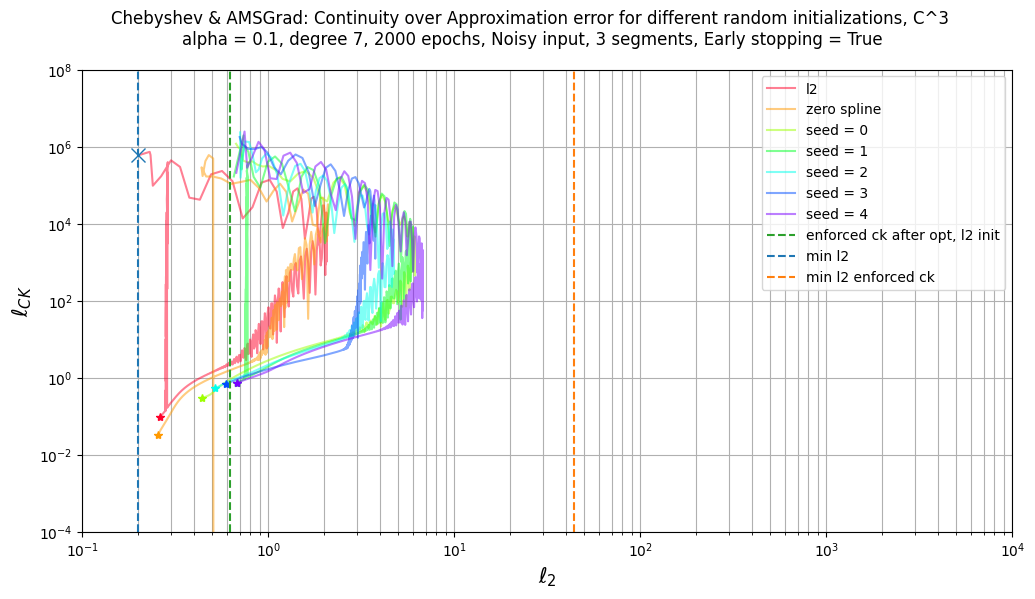

In [85]:
%store -r ellck_overell2_seed_results_no_reg
plot_l2_over_lck_plot(ellck_overell2_seed_results_no_reg, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_alpha', early_stopping=early_stopping, xlim=(1e-1,1e4), ylim=(1e-4,1e8))

### Interpretation

With $C^k$ regularization, different coefficient initializations lead to a similar remaining approximation error, but slightly different remaining continuity errors.
Without $C^k$ regularization, different coefficient initializations' results lead to a more scattered outcome in terms of both remaining approximation and continuity errors.
While approximation errors are higher in all cases, remaining continuity errors are lower in most (as it can be expected).
Interestingly, least squares initialization, in both observed scenarios, is not necessarily the one with the lowest remaining $\ell_2$ and/or $\ell_{CK}$ loss.
This most like is due to the noisy input data, where $\ell_2$ initialization will leave you with considerable discontinuities at boundary points.

All observed optimization results show clearly lower remaining $\ell_2$ losses than performing a conventional least squares fit with subsequent strictly establishment of continuity via algorithm.
Strictly establishing continuity after optimization with alpha = 0.1 increases remaining approximation errors quite considerably.

**Best initialization result: Zero spline**

## Increasing alpha = 0.9

In [86]:
alpha = 0.9

In [31]:
ellck_overell2_seed_results2 = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results2

Stored 'ellck_overell2_seed_results2' (list)


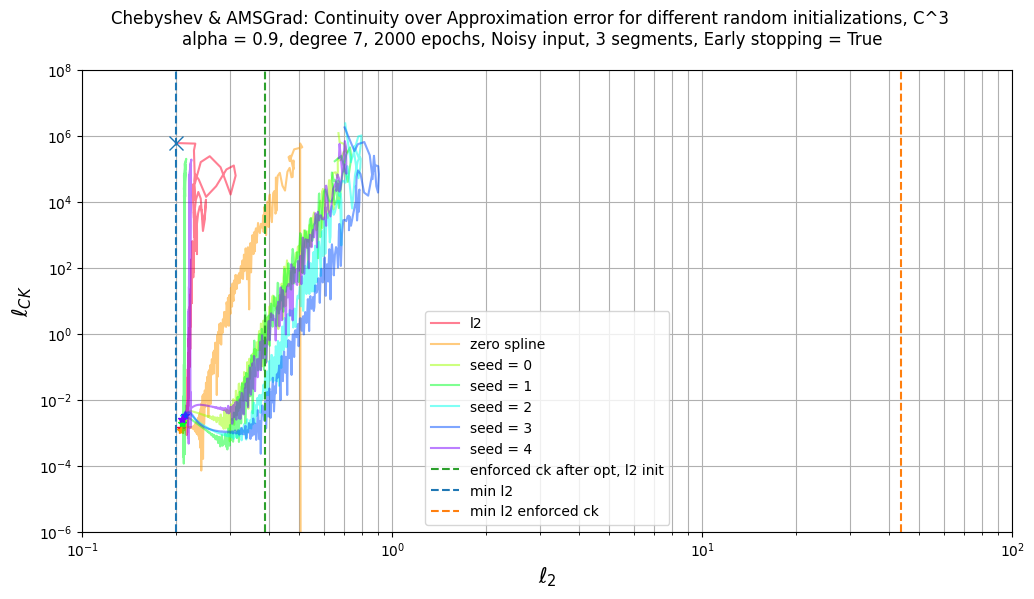

In [88]:
%store -r ellck_overell2_seed_results2
plot_l2_over_lck_plot(ellck_overell2_seed_results2, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_alpha', early_stopping=early_stopping, xlim=(1e-1,1e2), ylim=(1e-6,1e8))

### No regularization

In [33]:
ellck_overell2_seed_results2_no_reg = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, False, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results2_no_reg

Stored 'ellck_overell2_seed_results2_no_reg' (list)


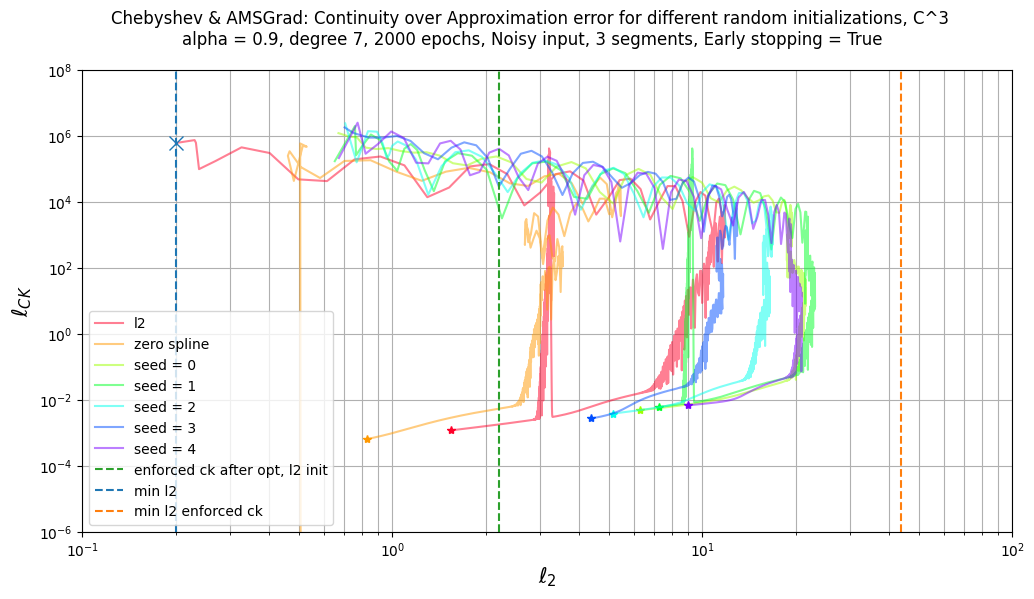

In [89]:
%store -r ellck_overell2_seed_results2_no_reg
plot_l2_over_lck_plot(ellck_overell2_seed_results2_no_reg, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_alpha', early_stopping=early_stopping, xlim=(1e-1,1e2), ylim=(1e-6,1e8))

### Interpretation

With $C^k$ regularization, increasing the value alpha expectedly leads to lower remaining continuity errors.
Interestingly, at the same time, remaining approximation errors are affected only mildly.
Without $C^k$ regularization, increasing the value of alpha lowers remaining continuity errors more significantly, 
but approximation results suffer severly and scatter more between different initializations.

All observed optimization results still show clearly lower remaining $\ell_2$ losses than performing a conventional least squares fit with subsequent strictly establishment of continuity via algorithm.

**Best initialization result: Zero spline / $\ell_2$ initialization**

## Down from here: Considering only results with $C^k$-regularization

### Where do different alphas end up for a fixed seed?

In [90]:
params = np.arange(0, 1, 0.2)
params = np.append(params, 0.9)
params = np.append(params, 0.95)
params = np.append(params, 0.99)
params = np.append(params, 0.999)
params = np.append(params, 0.9999)

early_stopping = True
patience = 100
polynum = 3

In [36]:
ellck_overell2_fixed_seed_results2 = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_seed')
%store ellck_overell2_fixed_seed_results2

Stored 'ellck_overell2_fixed_seed_results2' (list)


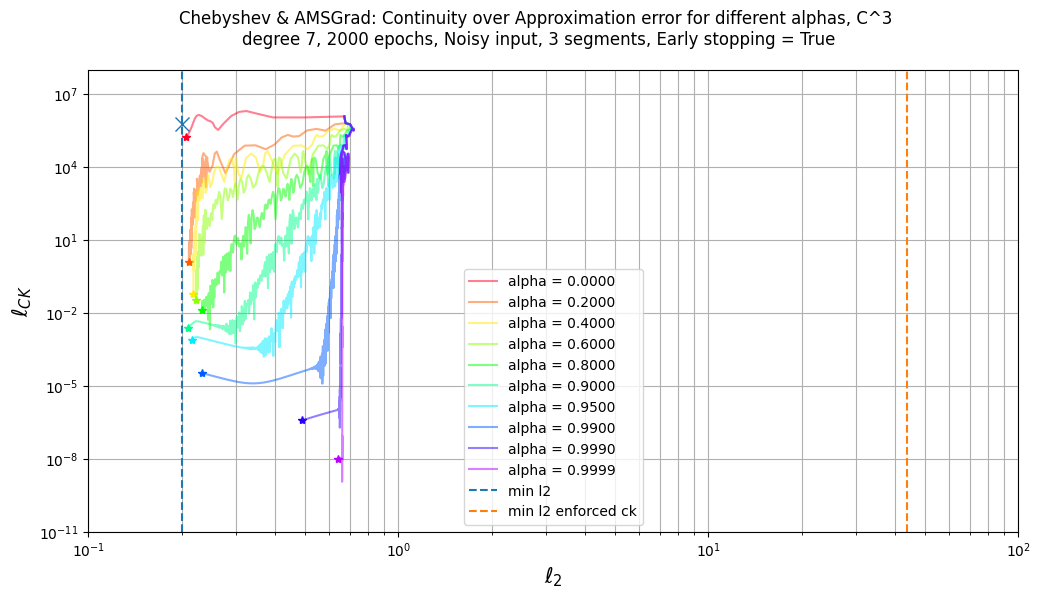

In [91]:
%store -r ellck_overell2_fixed_seed_results2
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results2, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_seed', True, digits=4, xlim=(1e-1,1e2), ylim=(1e-11,1e8))

#### Increasing number of polynomial segments

In [95]:
polynum = 4

In [39]:
ellck_overell2_fixed_seed_results3 = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_seed')
%store ellck_overell2_fixed_seed_results3

Stored 'ellck_overell2_fixed_seed_results3' (list)


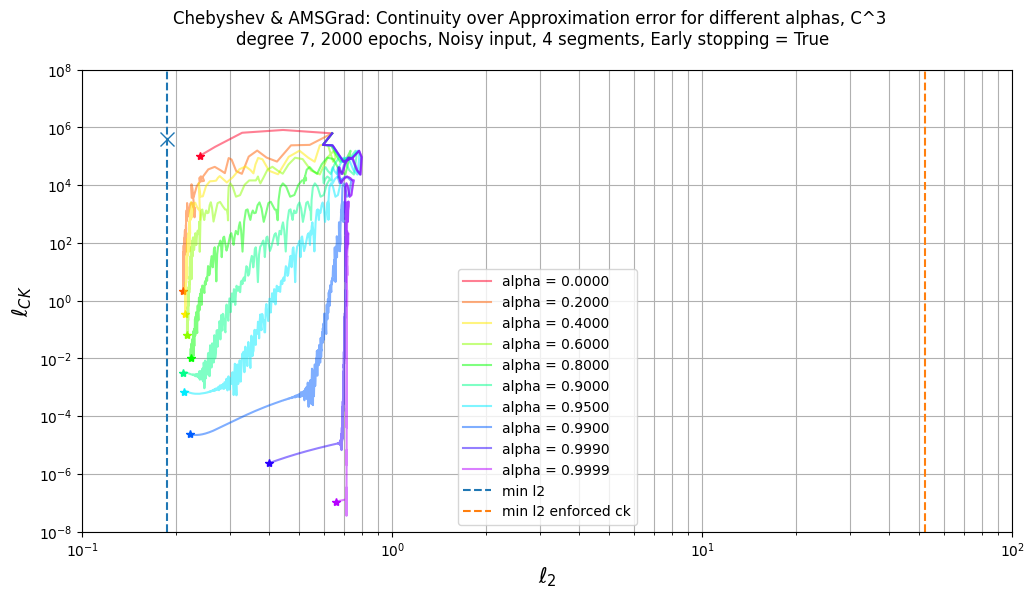

In [96]:
%store -r ellck_overell2_fixed_seed_results3
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results3, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_seed', True, digits=4, xlim=(1e-1,1e2), ylim=(1e-8,1e8))

### Where do different alphas end up for a fixed seed and enforced continuity after optimization?

In [41]:
ellck_overell2_fixed_seed_results2_enforced_ck = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_seed_enforce_ck')
%store ellck_overell2_fixed_seed_results2_enforced_ck

Stored 'ellck_overell2_fixed_seed_results2_enforced_ck' (list)


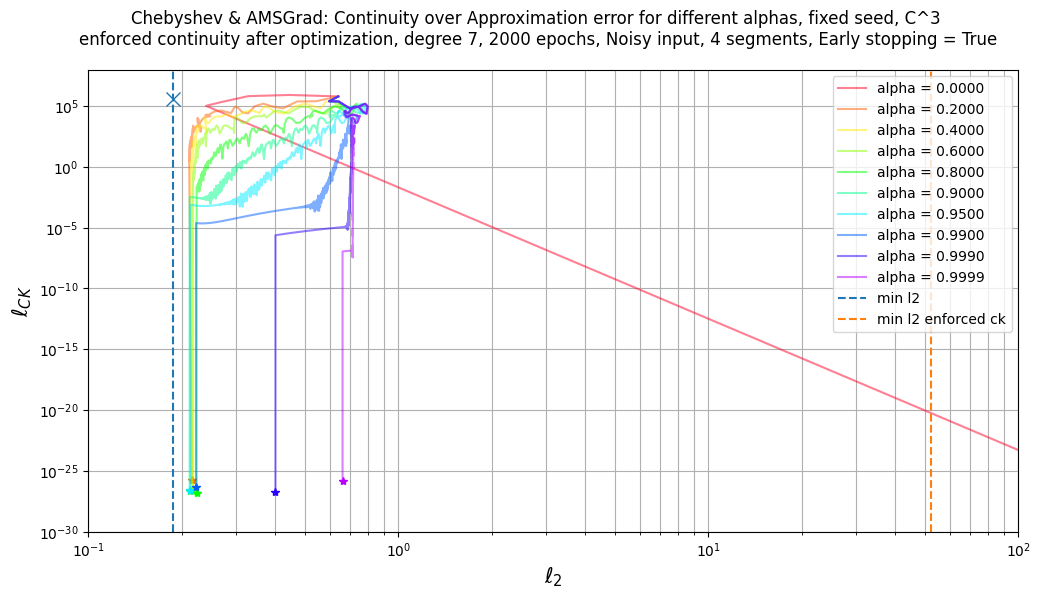

In [97]:
%store -r ellck_overell2_fixed_seed_results2_enforced_ck
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results2_enforced_ck, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', 'fixed_seed_enforce_ck', True, digits=4, xlim=(1e-1,1e2), ylim=(1e-30,1e8))

## Interpretation

With a random initialization of polynomial coefficients, increasing the value alpha expectedly leads to lower remaining continuity errors,
with remaining approximation errors growing slightly.
All observed optimization results still show clearly lower remaining $\ell_2$ losses than performing a conventional least squares fit with subsequent strictly establishment of continuity via algorithm.

Increasing the number of polynomials in this "noisy" scenario leads to slight improvements of remaining approximation errors vs. slight worsening of remaining continuity errors.

Enforcing continuity after optimization for a result with alpha = 0.0 increases the approximation error drastically, even beyond the point of 
where a conventional least squares fit with subsequent establishment of continuity would end up at.
**Strictly establishing continuity after optimization for a result with alpha > 0 does only affect remaining approximation errors mildly.**

### Where do different alphas end up for l2 initialization?

In [46]:
ellck_overell2_fixed_seed_results_var_l2 = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_l2')
%store ellck_overell2_fixed_seed_results_var_l2

Stored 'ellck_overell2_fixed_seed_results_var_l2' (list)


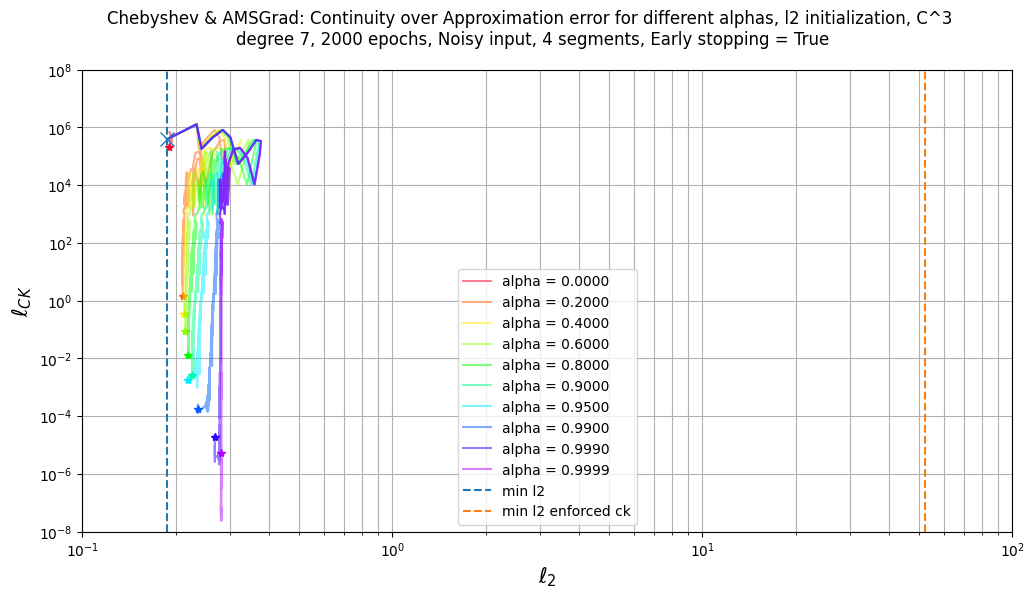

In [98]:
%store -r ellck_overell2_fixed_seed_results_var_l2
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_var_l2, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2', early_stopping=early_stopping, input='Noisy', digits=4, xlim=(1e-1,1e2), ylim=(1e-8,1e8))

### Where do different alphas end up for l2 initialization and enforced continuity after optimization?

In [48]:
ellck_overell2_fixed_seed_results_var_l2_enforced_ck = generate_l2_over_lck_plot_data(params, xsinvar, ys2gauss[2], polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_l2_enforce_ck')
%store ellck_overell2_fixed_seed_results_var_l2_enforced_ck

Stored 'ellck_overell2_fixed_seed_results_var_l2_enforced_ck' (list)


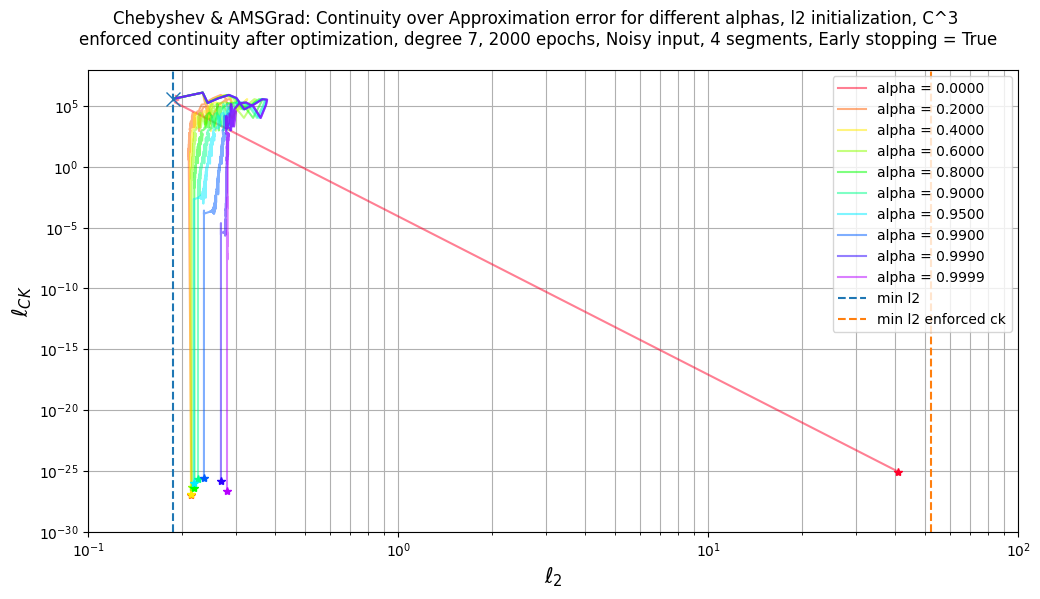

In [99]:
%store -r ellck_overell2_fixed_seed_results_var_l2_enforced_ck
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_var_l2_enforced_ck, params, xsinvar, ys2gauss[2], ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2_enforce_ck', early_stopping=early_stopping, input='Noisy', digits=4, xlim=(1e-1,1e2), ylim=(1e-30,1e8))

# Sine data with increasing frequency ("unnoisy")

### alpha = 0.1

In [107]:
params = np.arange(-2, 5, 1)
polynum = 3
epochs = 2000
alpha = 0.1

In [108]:
ellck_overell2_seed_results_sine = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results_sine

Stored 'ellck_overell2_seed_results_sine' (list)


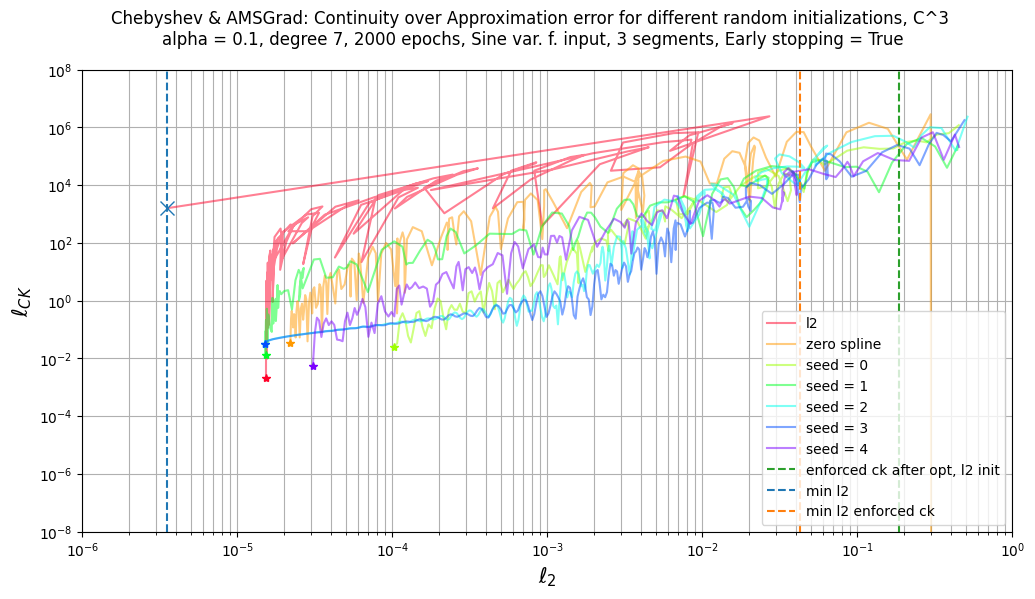

In [109]:
%store -r ellck_overell2_seed_results_sine
plot_l2_over_lck_plot(ellck_overell2_seed_results_sine, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_alpha', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e0), ylim=(1e-8,1e8))

### No regularization

In [113]:
ellck_overell2_seed_results_sine_no_reg = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, False, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results_sine_no_reg

Stored 'ellck_overell2_seed_results_sine_no_reg' (list)


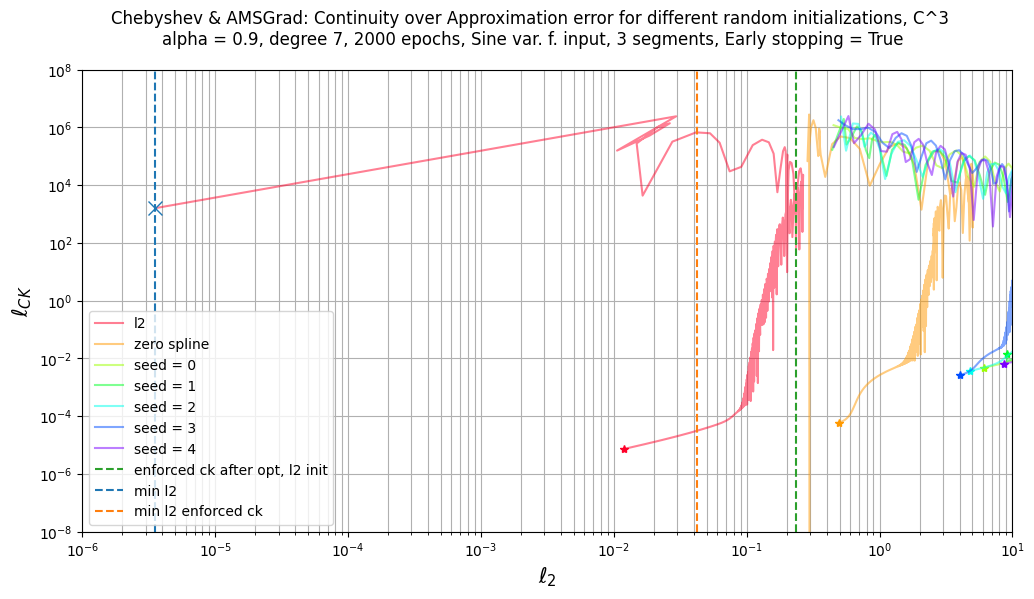

In [114]:
%store -r ellck_overell2_seed_results_sine_no_reg
plot_l2_over_lck_plot(ellck_overell2_seed_results_sine_no_reg, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_alpha', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e1), ylim=(1e-8,1e8))

Contrary to noisy input data, remaining approximation errors are now scattered more throughout different initializations.
With $\ell_{CK}$ regularization, observed optimization results show clearly lower remaining $\ell_2$ losses than performing a conventional least squares fit with subsequent strictly establishment of continuity via algorithm. This is not the case for unregularized optimization, which is outperformed even more clearly with "unnoisy" data.

**Best initialization result: $\ell_2$**

### alpha = 0.9

In [110]:
alpha = 0.9

In [111]:
ellck_overell2_seed_results_sine2 = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results_sine2

Stored 'ellck_overell2_seed_results_sine2' (list)


no stored variable or alias ellck_overell2_seed_results2_sine2


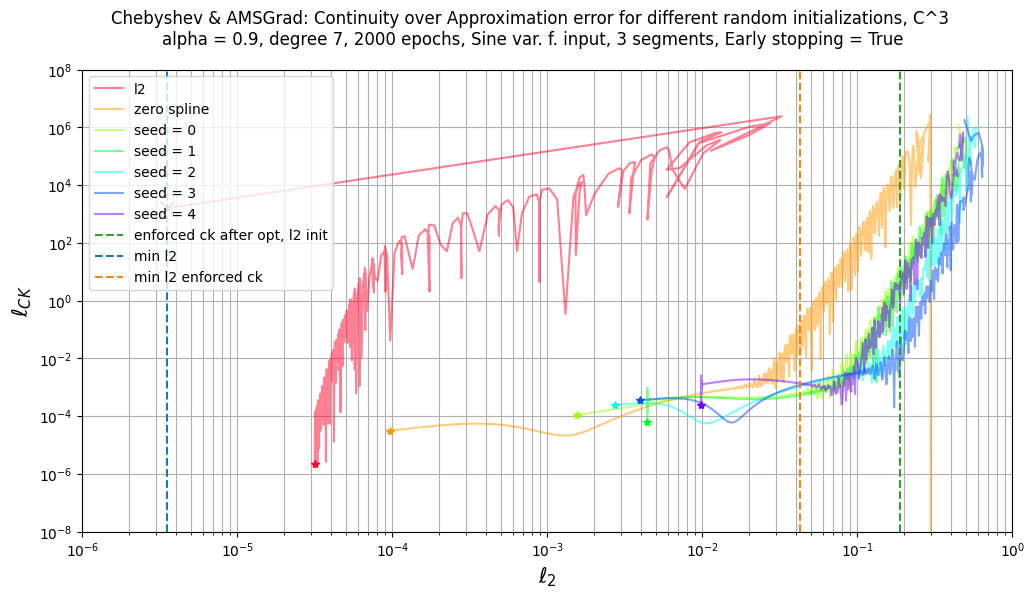

In [112]:
%store -r ellck_overell2_seed_results2_sine2
plot_l2_over_lck_plot(ellck_overell2_seed_results_sine2, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_alpha', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e0), ylim=(1e-8,1e8))

### No regularization

In [115]:
ellck_overell2_seed_results_sine_no_reg2 = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, False, basis, optimizer, early_stopping, patience, 'fixed_alpha')
%store ellck_overell2_seed_results_sine_no_reg2

Stored 'ellck_overell2_seed_results_sine_no_reg2' (list)


no stored variable or alias ellck_overell2_seed_results2_sine_no_reg2


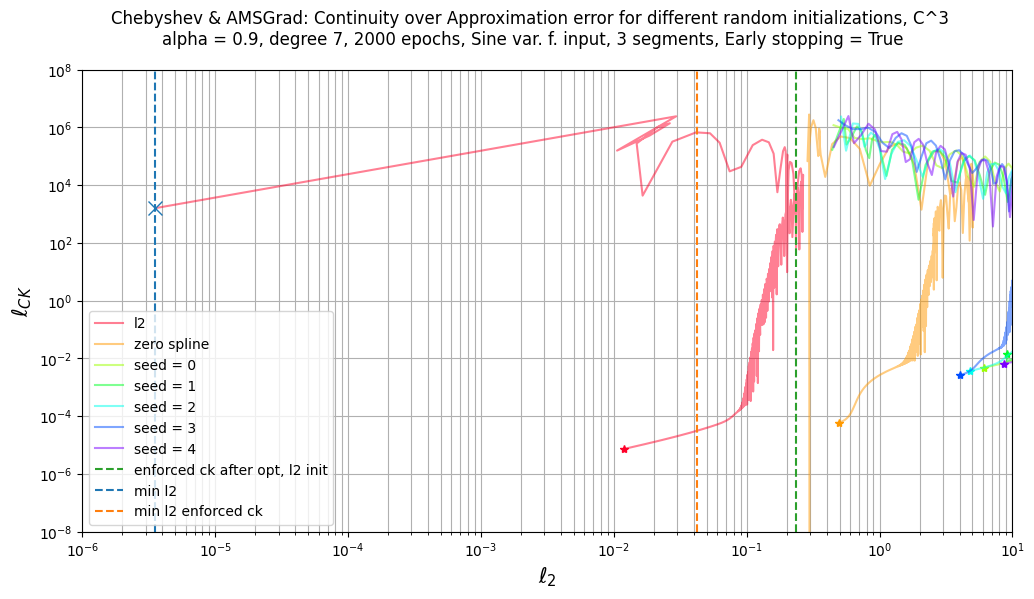

In [116]:
%store -r ellck_overell2_seed_results2_sine_no_reg2
plot_l2_over_lck_plot(ellck_overell2_seed_results_sine_no_reg2, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_alpha', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e1), ylim=(1e-8,1e8))

### Interpretation

**Contrary to noisy input data, increasing alpha now has a more severe effect on the remaining approximation error.
$\ell_2$ initialization is the clear favourite with unnoisy data**.

## Down from here: Considering only results with $C^k$-regularization

### Where do different alphas end up for a fixed seed?

In [126]:
params = np.arange(0, 1, 0.2)
params = np.append(params, 0.85)
params = np.append(params, 0.9)
params = np.append(params, 0.95)
params = np.append(params, 0.99)
params = np.append(params, 0.999)

In [64]:
ellck_overell2_fixed_seed_results_sin = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_seed')
%store ellck_overell2_fixed_seed_results_sin

Stored 'ellck_overell2_fixed_seed_results_sin' (list)


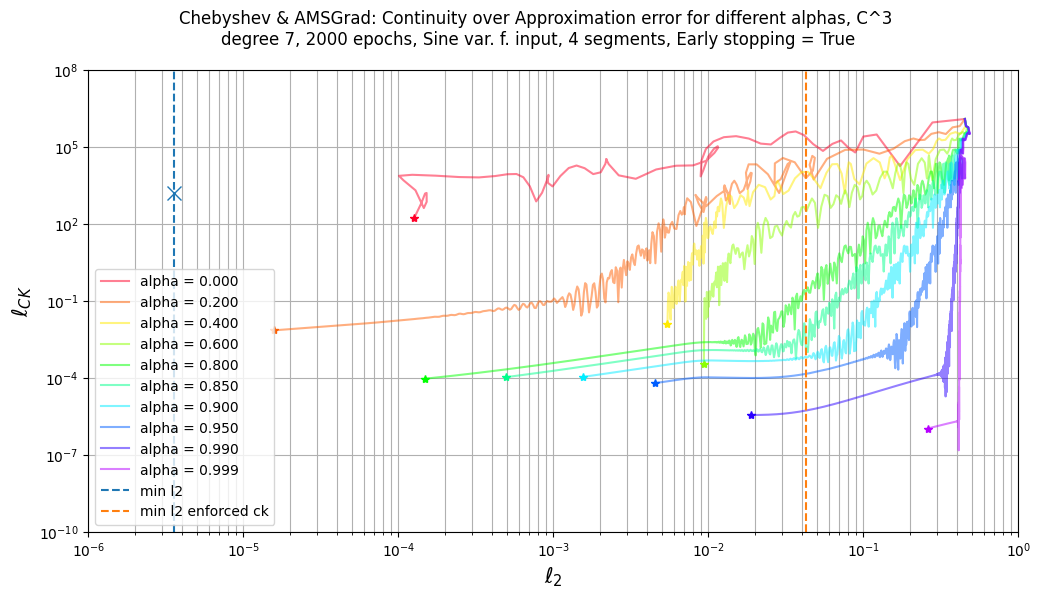

In [125]:
%store -r ellck_overell2_fixed_seed_results_sin
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_sin, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_seed', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e0), ylim=(1e-10,1e8))

### Where do different alphas end up for a fixed seed and enforced continuity after optimization?

In [67]:
ellck_overell2_fixed_seed_results_sin_enforced_ck = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_seed_enforce_ck')
%store ellck_overell2_fixed_seed_results_sin_enforced_ck

Stored 'ellck_overell2_fixed_seed_results_sin_enforced_ck' (list)


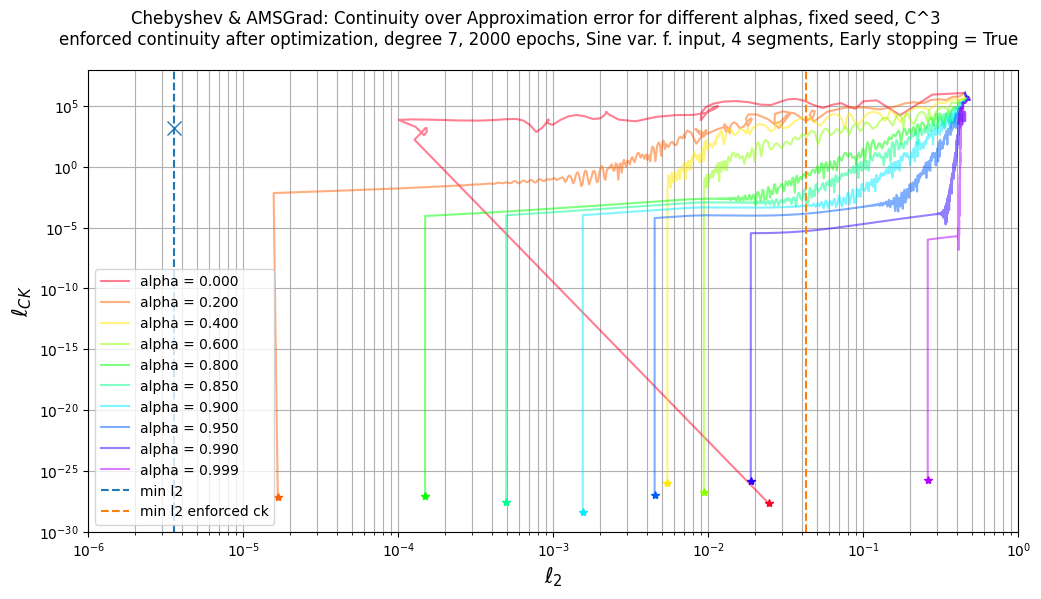

In [128]:
%store -r ellck_overell2_fixed_seed_results_sin_enforced_ck
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_sin_enforced_ck, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_seed_enforce_ck', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e0), ylim=(1e-30,1e8))

## Interpretation

Again, enforcing continuity after optimization for a result with alpha = 0.0 increases the approximation error drastically, while
for a result with alpha > 0 remaining approximation errors are only affected mildly.

### Where do different alphas end up for l2 initialization?

In [69]:
ellck_overell2_fixed_seed_results_sin_l2 = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_l2')
%store ellck_overell2_fixed_seed_results_sin_l2

Stored 'ellck_overell2_fixed_seed_results_sin_l2' (list)


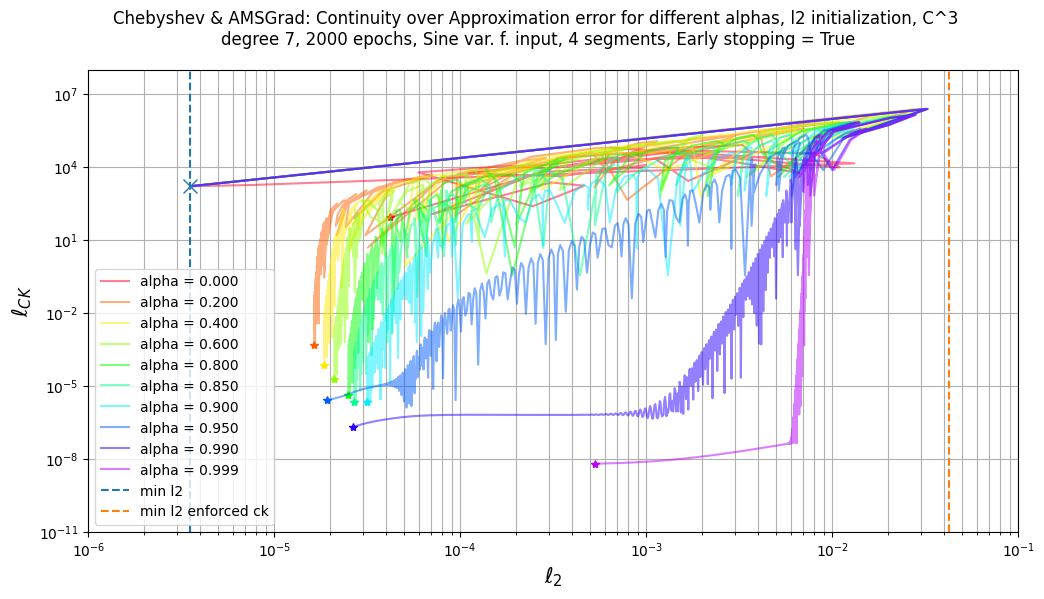

In [129]:
%store -r ellck_overell2_fixed_seed_results_sin_l2
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_sin_l2, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2', early_stopping=early_stopping, input='Sine var. f.', xlim=(1e-6,1e-1), ylim=(1e-11,1e8))

### Interpretation

With least squares initialization of polynomial coefficients, the behaviour is analogous to the one of random initialization with one difference:
Remaining approximation errors are lower.

### Increase number of polynomial segments

In [130]:
polynum = 4

In [73]:
ellck_overell2_fixed_seed_results_sin_l2_4seg = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_l2')
%store ellck_overell2_fixed_seed_results_sin_l2_4seg

Stored 'ellck_overell2_fixed_seed_results_sin_l2_4seg' (list)


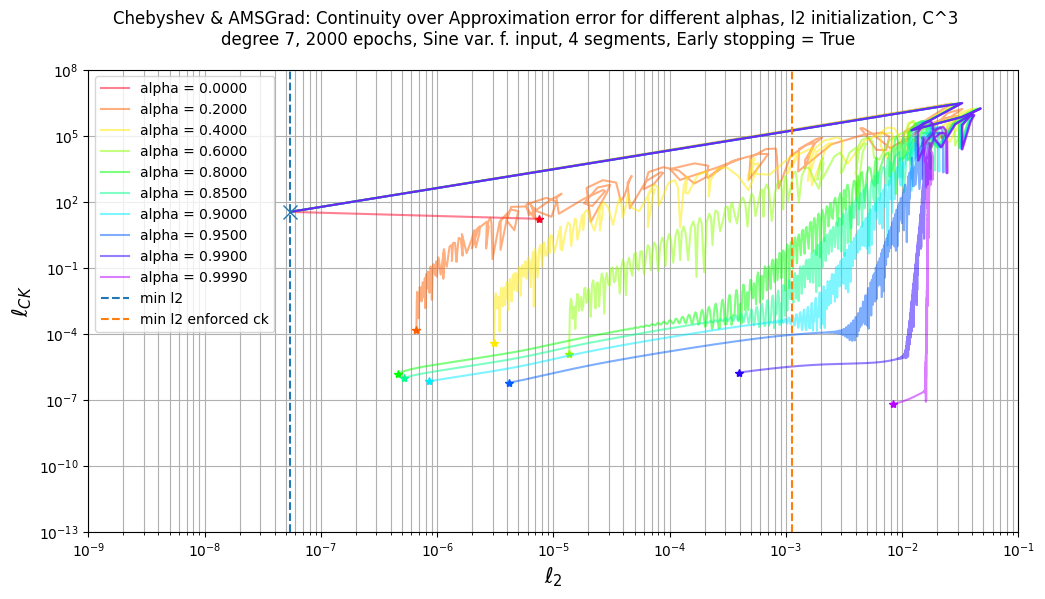

In [131]:
%store -r ellck_overell2_fixed_seed_results_sin_l2_4seg
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_sin_l2_4seg, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2', early_stopping=early_stopping, input='Sine var. f.', digits=4, xlim=(1e-9,1e-1), ylim=(1e-13,1e8))

### Where do different alphas end up for l2 initialization and enforced continuity after optimization?

In [75]:
ellck_overell2_fixed_seed_results_sin_l2_4seg_enforced_ck = generate_l2_over_lck_plot_data(params, xsinvar, ysinvar, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=100, mode='fixed_l2_enforce_ck')
%store ellck_overell2_fixed_seed_results_sin_l2_4seg_enforced_ck

Stored 'ellck_overell2_fixed_seed_results_sin_l2_4seg_enforced_ck' (list)


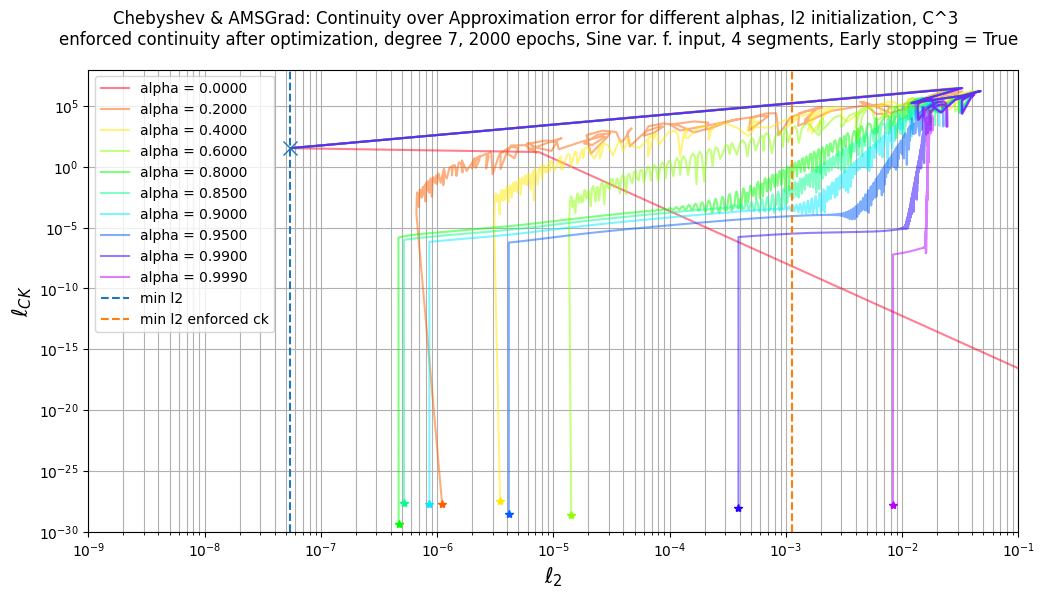

In [134]:
%store -r ellck_overell2_fixed_seed_results_sin_l2_4seg_enforced_ck
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_sin_l2_4seg_enforced_ck, params, xsinvar, ysinvar, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2_enforce_ck', early_stopping=early_stopping, input='Sine var. f.', digits=4, xlim=(1e-9,1e-1), ylim=(1e-30,1e8))

### Interpretation

With a least squares initialization of polynomial coefficients, the behaviour is analogous to the one of random initialization with one difference:
Remaining approximation errors are lower.

# Testing low variance input data

In [138]:
polynum = 2

In [148]:
ellck_overell2_fixed_seed_results_simple_l2 = generate_l2_over_lck_plot_data(params, xs2, ys2, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=500, mode='fixed_l2')
%store ellck_overell2_fixed_seed_results_simple_l2

Stored 'ellck_overell2_fixed_seed_results_simple_l2' (list)


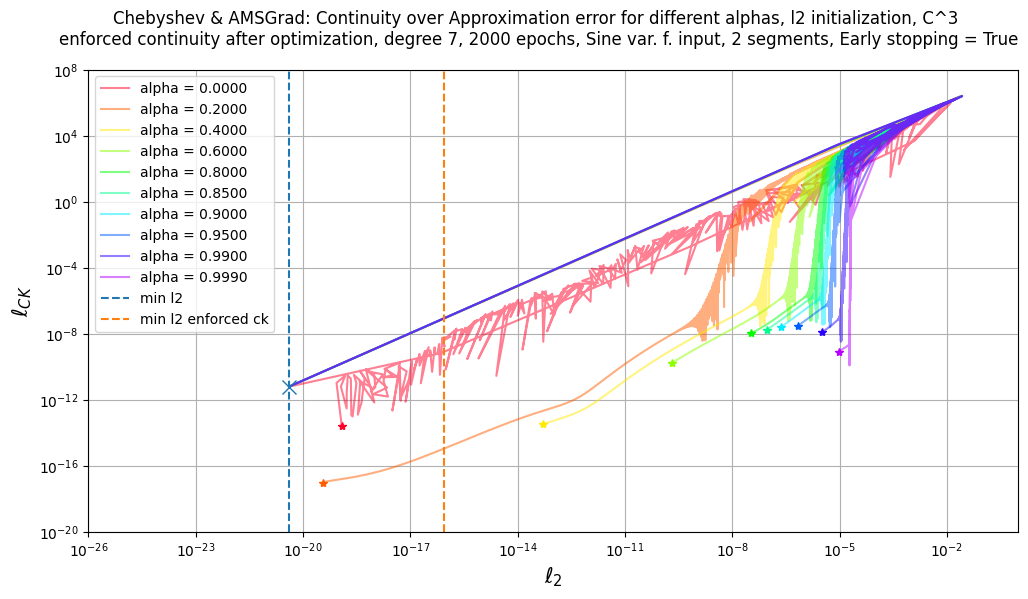

In [149]:
%store -r ellck_overell2_fixed_seed_results_simple_l2
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_simple_l2, params, xs2, ys2, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2_enforce_ck', early_stopping=early_stopping, input='Sine var. f.', digits=4, xlim=(1e-26,1e-0), ylim=(1e-20,1e8))

In [150]:
ellck_overell2_fixed_seed_results_simple_l2_enforce = generate_l2_over_lck_plot_data(params, xs2, ys2, polynum, ck, degree, epochs, alpha, learning_rate, ck_regularization, basis, optimizer, early_stopping=True, patience=500, mode='fixed_l2_enforce_ck')
%store ellck_overell2_fixed_seed_results_simple_l2_enforce

Stored 'ellck_overell2_fixed_seed_results_simple_l2_enforce' (list)


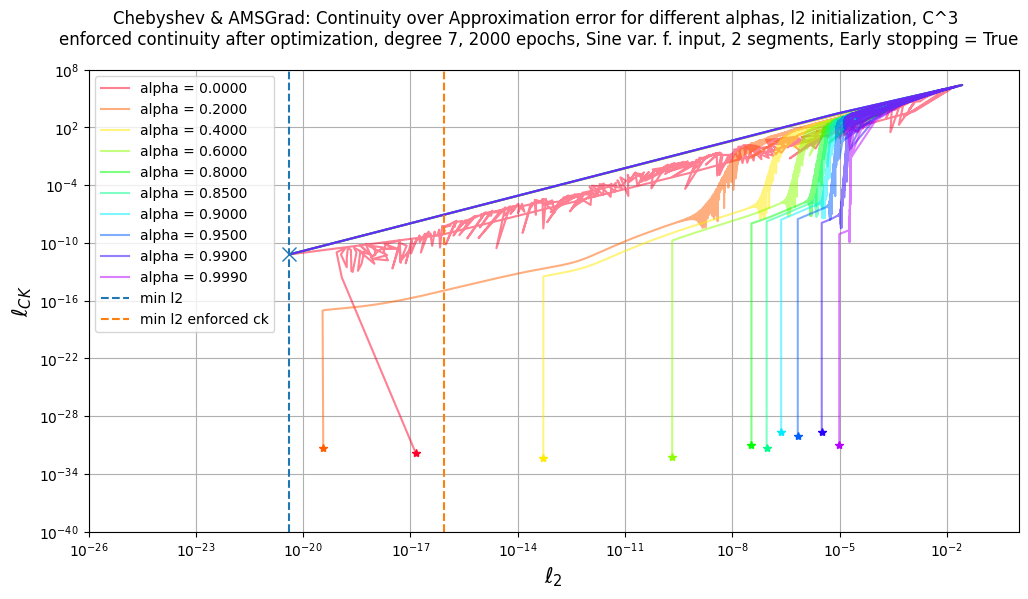

In [151]:
%store -r ellck_overell2_fixed_seed_results_simple_l2_enforce
plot_l2_over_lck_plot(ellck_overell2_fixed_seed_results_simple_l2_enforce, params, xs2, ys2, ck, alpha, 'Chebyshev', 'AMSGrad', mode='fixed_l2_enforce_ck', early_stopping=early_stopping, input='Sine var. f.', digits=4, xlim=(1e-26,1e-0), ylim=(1e-40,1e8))

### Interpretation

The band between remaining approximation error of a conventional least squares fit and approximation error of this fit after strictly establishing continuity via algorithm
depends on the remaining discontinuities at boundary points after fitting. 
These tend to be higher with noisy data / data with more variance / lower number of polynomials, leaving us with a wider band of where our optimization leads to better results than performing
l2 fit with strict continuity establishment.
In case of a wider band, we can also have a wider range of alpha values that make sense.
Leaving out some scenarios where local optima of higher alpha values have a lower approximation error than lower ones,
we generally see a tendency of rising approximation errors with rising alpha values.
For high variance / noisy input data, we observe results that lie within the aforementioned band through the range 0 < alpha <~ 0.9,
with alpha values of > ~0.9 tendentially having ever higher approximation errors, thus leaving the band.

**With low variance data, this effect already can be observed with lambda values > ~0.3, leaving us with a smaller range of possible alphas that make sense.**